## Work
1. 請比較使用 l1, l1_l2 及不同比例下的訓練結果

In [ ]:
l2, 0.01, loss: 1.6091 - acc: 0.5261 - val_loss: 1.7557 - val_acc: 0.4833
    0.0001, loss: 1.0356 - acc: 0.6855 - val_loss: 1.5104 - val_acc: 0.5350
    0.00000001, loss: 0.8719 - acc: 0.6961 - val_loss: 1.3949 - val_acc: 0.5326
    0.000000000001, loss: 0.8635 - acc: 0.6982 - val_loss: 1.3996 - val_acc: 0.5363
l1, 0.01, loss: 2.4626 - acc: 0.0965 - val_loss: 2.4625 - val_acc: 0.1000
    0.0001, loss: 2.6399 - acc: 0.6265 - val_loss: 2.9009 - val_acc: 0.5360
    0.00000001, loss: 0.8792 - acc: 0.6931 - val_loss: 1.4982 - val_acc: 0.5057
    0.000000000001, loss: 0.8847 - acc: 0.6885 - val_loss: 1.4361 - val_acc: 0.5170
l1_l2, 0.01, loss: 2.4614 - acc: 0.0971 - val_loss: 2.4614 - val_acc: 0.100
       0.0001, loss: 1.7543 - acc: 0.4799 - val_loss: 1.7755 - val_acc: 0.472
       0.00000001, loss: 1.6123 - acc: 0.5248 - val_loss: 1.7821 - val_acc: 0.468
       0.000000000001,loss: 1.6116 - acc: 0.5251 - val_loss: 1.6786 - val_acc: 0.4953

In [1]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.regularizers import l1, l2, l1_l2
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128], l2_ratio=1e-4):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1), 
                                   kernel_regularizer=l1(l2_ratio))(input_layer)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1),
                                   kernel_regularizer=l1(l2_ratio))(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
"""Code Here
設定超參數
"""
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 256
MOMENTUM = 0.95
L2_EXP = [1e-2, 1e-4, 1e-8, 1e-12]

In [7]:
results = {}
"""Code Here
撰寫你的訓練流程並將結果用 dictionary 紀錄
"""
for regulizer_ratio in L2_EXP:
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Experiment with Regulizer = %.6f" % (regulizer_ratio))
    model = build_mlp(input_shape=x_train.shape[1:], l2_ratio=regulizer_ratio)
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True)
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]
    
    exp_name_tag = "exp-l2-%s" % str(regulizer_ratio)
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}


W0807 14:15:45.698765  7692 module_wrapper.py:136] From C:\Users\User\Anaconda3\lib\site-packages\tensorflow_core\python\util\module_wrapper.py:163: The name tf.reset_default_graph is deprecated. Please use tf.compat.v1.reset_default_graph instead.

W0807 14:15:45.748654  7692 module_wrapper.py:136] From C:\Users\User\Anaconda3\lib\site-packages\tensorflow_core\python\util\module_wrapper.py:163: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0807 14:15:45.867341  7692 deprecation.py:323] From C:\Users\User\Anaconda3\lib\site-packages\tensorflow_core\python\ops\math_grad.py:1423: where (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Experiment with Regulizer = 0.010000
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
_________________________________________________________________
Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [=====================

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 5s 98us/step - loss: 5.9930 - acc: 0.2781 - val_loss: 5.8040 - val_acc: 0.3455
Epoch 2/50
50000/50000 [==============================] - 5s 95us/step - loss: 5.7100 - acc: 0.3687 - val_loss: 5.6258 - val_acc: 0.3857
Epoch 3/50
50000/50000 [==============================] - 5s 96us/step - loss: 5.5612 - acc: 0.3981 - val_loss: 5.4976 - val_acc: 0.4106
Epoch 4/50
50000/50000 [==============================] - 5s 95us/step - loss: 5.4395 - acc: 0.4199 - val_loss: 5.3789 - val_acc: 0.4300
Epoch 5/50
50000/50000 [==============================] - 5s 96us/step - loss: 5.3287 - acc: 0.4359 - val_loss: 5.2835 - val_acc: 0.4395
Epoch 6/50
50000/50000 [==============================] - 5s 95us/step - loss: 5.2274 - acc: 0.4486 - val_loss: 5.1994 - val_acc: 0.4418
Epoch 7/50
50000/50000 [==============================] - 5s 95us/step - loss: 5.1322 - acc: 0.4581 - val_loss: 5.1114 - val_acc

50000/50000 [==============================] - 5s 92us/step - loss: 1.8209 - acc: 0.3592 - val_loss: 1.7781 - val_acc: 0.3807
Epoch 3/50
50000/50000 [==============================] - 5s 92us/step - loss: 1.7407 - acc: 0.3888 - val_loss: 1.7107 - val_acc: 0.4033
Epoch 4/50
50000/50000 [==============================] - 5s 93us/step - loss: 1.6817 - acc: 0.4105 - val_loss: 1.6580 - val_acc: 0.4179
Epoch 5/50
50000/50000 [==============================] - 5s 92us/step - loss: 1.6334 - acc: 0.4276 - val_loss: 1.6244 - val_acc: 0.4278
Epoch 6/50
50000/50000 [==============================] - 5s 92us/step - loss: 1.5936 - acc: 0.4405 - val_loss: 1.5843 - val_acc: 0.4420
Epoch 7/50
50000/50000 [==============================] - 5s 92us/step - loss: 1.5581 - acc: 0.4531 - val_loss: 1.5541 - val_acc: 0.4558
Epoch 8/50
50000/50000 [==============================] - 5s 92us/step - loss: 1.5271 - acc: 0.4628 - val_loss: 1.5517 - val_acc: 0.4521
Epoch 9/50
50000/50000 [============================

50000/50000 [==============================] - 5s 96us/step - loss: 1.7266 - acc: 0.3930 - val_loss: 1.6969 - val_acc: 0.4071
Epoch 4/50
50000/50000 [==============================] - 5s 95us/step - loss: 1.6660 - acc: 0.4128 - val_loss: 1.6508 - val_acc: 0.4164
Epoch 5/50
50000/50000 [==============================] - 5s 95us/step - loss: 1.6207 - acc: 0.4307 - val_loss: 1.6022 - val_acc: 0.4357
Epoch 6/50
50000/50000 [==============================] - 5s 95us/step - loss: 1.5808 - acc: 0.4470 - val_loss: 1.5743 - val_acc: 0.4470
Epoch 7/50
50000/50000 [==============================] - 5s 95us/step - loss: 1.5477 - acc: 0.4568 - val_loss: 1.5813 - val_acc: 0.4442
Epoch 8/50
50000/50000 [==============================] - 5s 95us/step - loss: 1.5176 - acc: 0.4665 - val_loss: 1.5293 - val_acc: 0.4539
Epoch 9/50
50000/50000 [==============================] - 5s 95us/step - loss: 1.4882 - acc: 0.4775 - val_loss: 1.5004 - val_acc: 0.4656
Epoch 10/50
50000/50000 [===========================

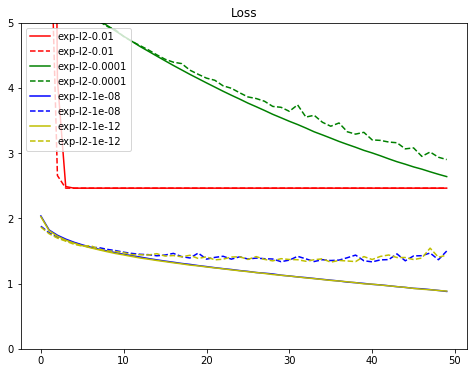

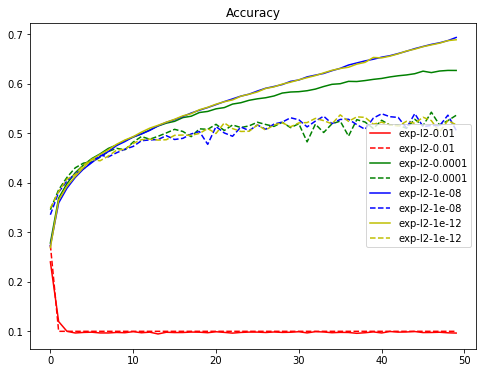

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
"""Code Here
將結果繪出
"""
color_bar = ["r", "g", "b", "y", "m", "k"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()

In [9]:
from keras.regularizers import l1, l2, l1_l2
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128], l2_ratio=1e-4):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1), 
                                   kernel_regularizer=l1_l2(l2_ratio))(input_layer)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1),
                                   kernel_regularizer=l1_l2(l2_ratio))(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [10]:
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 256
MOMENTUM = 0.95
L2_EXP = [1e-2, 1e-4, 1e-8, 1e-12]

In [11]:
results = {}
"""Code Here
撰寫你的訓練流程並將結果用 dictionary 紀錄
"""
for regulizer_ratio in L2_EXP:
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Experiment with Regulizer = %.6f" % (regulizer_ratio))
    model = build_mlp(input_shape=x_train.shape[1:], l2_ratio=regulizer_ratio)
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True)
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]
    
    exp_name_tag = "exp-l2-%s" % str(regulizer_ratio)
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}

Experiment with Regulizer = 0.010000
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
_________________________________________________________________
Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [=====================

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 6s 119us/step - loss: 18.7853 - acc: 0.2759 - val_loss: 17.3365 - val_acc: 0.3475
Epoch 2/50
50000/50000 [==============================] - 6s 113us/step - loss: 16.1280 - acc: 0.3568 - val_loss: 14.9695 - val_acc: 0.3682
Epoch 3/50
50000/50000 [==============================] - 6s 112us/step - loss: 13.9479 - acc: 0.3788 - val_loss: 12.9635 - val_acc: 0.3899
Epoch 4/50
50000/50000 [==============================] - 6s 113us/step - loss: 12.1006 - acc: 0.3912 - val_loss: 11.2666 - val_acc: 0.4011
Epoch 5/50
50000/50000 [==============================] - 6s 113us/step - loss: 10.5317 - acc: 0.4009 - val_loss: 9.8264 - val_acc: 0.4048
Epoch 6/50
50000/50000 [==============================] - 6s 113us/step - loss: 9.1969 - acc: 0.4075 - val_loss: 8.5920 - val_acc: 0.4050
Epoch 7/50
50000/50000 [==============================] - 6s 115us/step - loss: 8.0593 - acc: 0.4127 - val_loss: 

Epoch 2/50
50000/50000 [==============================] - 6s 111us/step - loss: 12.9959 - acc: 0.3608 - val_loss: 12.1079 - val_acc: 0.3742
Epoch 3/50
50000/50000 [==============================] - 6s 113us/step - loss: 11.3240 - acc: 0.3841 - val_loss: 10.5756 - val_acc: 0.3984
Epoch 4/50
50000/50000 [==============================] - 6s 111us/step - loss: 9.9127 - acc: 0.3997 - val_loss: 9.3024 - val_acc: 0.3919
Epoch 5/50
50000/50000 [==============================] - 6s 117us/step - loss: 8.7156 - acc: 0.4103 - val_loss: 8.1765 - val_acc: 0.4137
Epoch 6/50
50000/50000 [==============================] - 6s 115us/step - loss: 7.6956 - acc: 0.4144 - val_loss: 7.2381 - val_acc: 0.4195
Epoch 7/50
50000/50000 [==============================] - 6s 115us/step - loss: 6.8254 - acc: 0.4242 - val_loss: 6.4371 - val_acc: 0.4254
Epoch 8/50
50000/50000 [==============================] - 6s 115us/step - loss: 6.0816 - acc: 0.4293 - val_loss: 5.7474 - val_acc: 0.4306
Epoch 9/50
50000/50000 [======

50000/50000 [==============================] - 6s 111us/step - loss: 11.3352 - acc: 0.3795 - val_loss: 10.5868 - val_acc: 0.3909
Epoch 4/50
50000/50000 [==============================] - 6s 113us/step - loss: 9.9251 - acc: 0.3925 - val_loss: 9.2849 - val_acc: 0.4044
Epoch 5/50
50000/50000 [==============================] - 6s 111us/step - loss: 8.7263 - acc: 0.4031 - val_loss: 8.1867 - val_acc: 0.4082
Epoch 6/50
50000/50000 [==============================] - 6s 112us/step - loss: 7.7044 - acc: 0.4117 - val_loss: 7.2400 - val_acc: 0.4183
Epoch 7/50
50000/50000 [==============================] - 6s 111us/step - loss: 6.8338 - acc: 0.4184 - val_loss: 6.4375 - val_acc: 0.4204
Epoch 8/50
50000/50000 [==============================] - 6s 111us/step - loss: 6.0902 - acc: 0.4259 - val_loss: 5.7769 - val_acc: 0.4164
Epoch 9/50
50000/50000 [==============================] - 6s 112us/step - loss: 5.4547 - acc: 0.4305 - val_loss: 5.1736 - val_acc: 0.4256
Epoch 10/50
50000/50000 [==================

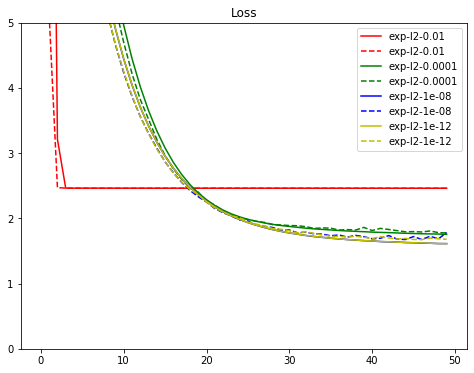

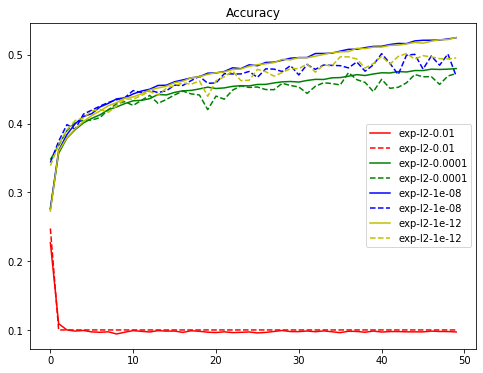

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline
"""Code Here
將結果繪出
"""
color_bar = ["r", "g", "b", "y", "m", "k"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()